In [ ]:
# In the previous file that is content based recommender engine I don't have the users and ratings they gave to each movie
# So now in this filtering I am going to use new dataset 


# Collaborative filtering

In [363]:
# importing all the necessary libraries

# for basic Operations
import pandas as pd
import numpy as np

# For Data Visualization
import seaborn as sns

from ast import literal_eval

# For Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors



# for converting pivot table to 2D array
from scipy.sparse import csr_matrix

# For ignoring warning
import warnings; warnings.simplefilter('ignore')

# for Interactive Analysis(@interact)
import ipywidgets as widgets
from ipywidgets import *
from ipywidgets import interact

In [364]:
# Lets Read the Movies Dataset
movies = pd.read_csv('movies.csv')

# lets check the shape of the movies dataset
movies.shape

(9742, 3)

In [365]:
# checking the movie datset
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [366]:
# Checking for any duplicate valuess
movies.duplicated().sum()

0

In [367]:
# Checking for missing values
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [368]:
# Lets Read the Ratings Dataset
ratings = pd.read_csv('ratings.csv')

# lets check the shape of the dataset
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [369]:
ratings.duplicated().sum()

0

In [370]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [371]:
# Removing the Timestamp column from the Data as it is an unnecessary column

ratings = ratings.drop(['timestamp'], axis = 1)

In [372]:
# As there is common column in both movie and rating dataset i.e movieID
# now here, Merging the ratings and movies dataset on the basis of movieId

merged_data = pd.merge(ratings, movies, on='movieId')

In [373]:
# Checking the Merged Data
merged_data.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [374]:
# Now as we can see from our dataset that each movie have different ratings from different users.
# So, making a total rating column as different user gave different ratings to a particular movie

In [375]:
# making a separate column for total_rating_Count

# number of ratings column is made by using couting same title of movies and putting that data in new dataset movie_rating_cout
movie_rating_count = merged_data.groupby('title')['rating'].count().reset_index().rename(columns={'rating':'num_rating'})

In [376]:
# now checking this dataset

movie_rating_count

,title,num_rating
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2
...,...,...
9714,eXistenZ (1999),22
9715,xXx (2002),24
9716,xXx: State of the Union (2005),5
9717,¡Three Amigos! (1986),26


In [377]:
# checking for duplicate values

movie_rating_count.duplicated().sum()

0

In [378]:
# checking for misiing values

movie_rating_count.isnull().sum()

title         0
num_rating    0
dtype: int64

In [379]:
# now merging it back into the merge_data and making a final dataset 

final = merged_data.merge(movie_rating_count, on='title', how='left')

In [380]:
final.head(5)

,userId,movieId,rating,title,genres,num_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215


In [381]:
# checking shape of final dataset
final.shape

(100836, 6)

In [382]:
final

,userId,movieId,rating,title,genres,num_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
...,...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller,1
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama,1
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller,1
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller,1


<H1> Statistical Filtering </H1>

In [383]:
# now lets fix a threshold value for total rating, to filter the dataset on the basis of no. of rating 
# we have to do this because we have many movies whose title is same but user is different
# but we have to pick the best threshold value using statistical approach
# for this we have to do some analysis of no. of ratings

<AxesSubplot:xlabel='num_rating'>

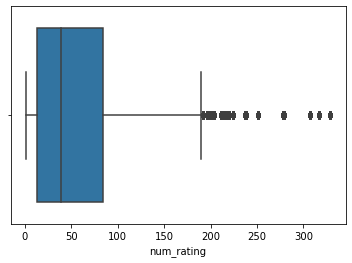

In [384]:
# we first use boxplot to find quantiles values 

sns.boxplot(final['num_rating'])

In [385]:
# here finding the quantile values at 0-100 th percentile having gap of 10
for i in range(0,101,10):
    print('{}th percentile value is {}'.format(i,final['num_rating'].quantile(i/100)))

0th percentile value is 1.0
10th percentile value is 4.0
20th percentile value is 10.0
30th percentile value is 17.0
40th percentile value is 27.0
50th percentile value is 39.0
60th percentile value is 52.0
70th percentile value is 69.0
80th percentile value is 100.0
90th percentile value is 143.0
100th percentile value is 329.0


In [386]:
# as we see from the graph that the num_rating threshold value is after the 50 
# so I took 69 as the threshold value

In [387]:
# applying the threshold filtering on num_rating

final = final[final['num_rating'] >= 69]

In [388]:
final.shape

(30554, 6)

# Pivot table

In [389]:
# Now making a pivot table to find the no. of unique users and their ratings to each movies

In [390]:
pvt_table = final.pivot_table(index='userId',columns='title',values='rating')

In [391]:
# filling NaN value with 0
pvt_table.fillna(0,inplace=True)

In [392]:
# Checking the pivot Table
pvt_table

title,2001: A Space Odyssey (1968),300 (2007),"40-Year-Old Virgin, The (2005)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Airplane! (1980),Aladdin (1992),Alien (1979),Aliens (1986),...,Waterworld (1995),What's Eating Gilbert Grape (1993),When Harry Met Sally... (1989),While You Were Sleeping (1995),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",X-Men (2000),X2: X-Men United (2003),Young Frankenstein (1974)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0
5,0.0,0.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,3.5,...,0.0,4.0,4.5,0.0,3.0,0.0,0.0,0.0,0.0,3.5
607,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,...,3.0,3.0,4.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0
608,3.0,5.0,0.0,3.5,2.0,2.5,0.0,3.0,4.0,4.5,...,3.0,0.0,0.0,2.5,3.0,3.5,2.5,4.0,4.0,0.0


In [393]:
# Now we can see that there are 602 users who give ratings to 264 movies

# correlation

In [394]:
# A correlation is a statistical measure of the relationship between two variables. 
# The measure is best used in variables that demonstrate a linear relationship between each other.

In [395]:
# finding similar movies with respect to Airplane! (1980)
# storing the correlation value in similarity

similarity = pvt_table.corrwith(pvt_table['Aliens (1986)'])

In [396]:
# sorting the movies correlation value in descending order

similarity.sort_values(ascending=False)[1:]

title
Alien (1979)                                             0.713246
Terminator, The (1984)                                   0.568841
Star Wars: Episode V - The Empire Strikes Back (1980)    0.518991
RoboCop (1987)                                           0.506469
Total Recall (1990)                                      0.503675
                                                           ...   
Sleepless in Seattle (1993)                              0.026366
Mr. Holland's Opus (1995)                                0.024670
Firm, The (1993)                                         0.008564
Quiz Show (1994)                                         0.005414
Cliffhanger (1993)                                      -0.019581
Length: 263, dtype: float64

In [397]:
co_Reln = similarity.sort_values(ascending=False).reset_index().rename(columns={0:'co-reln values'})[1:]

In [398]:
# printing the correlation values for the movie 'Aliens (1986)'
co_Reln 

,title,co-reln values
1,Alien (1979),0.713246
2,"Terminator, The (1984)",0.568841
3,Star Wars: Episode V - The Empire Strikes Back...,0.518991
4,RoboCop (1987),0.506469
5,Total Recall (1990),0.503675
...,...,...
259,Sleepless in Seattle (1993),0.026366
260,Mr. Holland's Opus (1995),0.024670
261,"Firm, The (1993)",0.008564
262,Quiz Show (1994),0.005414


In [399]:
# now recalling the final data that we made using merging
final

,userId,movieId,rating,title,genres,num_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
...,...,...,...,...,...,...
74478,594,1393,5.0,Jerry Maguire (1996),Drama|Romance,85
74479,599,1393,4.0,Jerry Maguire (1996),Drama|Romance,85
74480,600,1393,3.5,Jerry Maguire (1996),Drama|Romance,85
74481,606,1393,3.5,Jerry Maguire (1996),Drama|Romance,85


In [400]:
# now calculating the mean of the rating and counting the ratings of each movie
mean_data = final.groupby('title').agg({'title':'count','rating':'mean'}).rename(columns={'title':'total_ratings','rating':'avg_rating'}).reset_index()

In [401]:
mean_data

,title,total_ratings,avg_rating
0,2001: A Space Odyssey (1968),109,3.894495
1,300 (2007),80,3.681250
2,"40-Year-Old Virgin, The (2005)",74,3.547297
3,Ace Ventura: Pet Detective (1994),161,3.040373
4,Ace Ventura: When Nature Calls (1995),88,2.727273
...,...,...,...
259,Willy Wonka & the Chocolate Factory (1971),119,3.873950
260,"Wizard of Oz, The (1939)",92,3.880435
261,X-Men (2000),133,3.699248
262,X2: X-Men United (2003),76,3.723684


In [402]:
# fetching titles
titles = mean_data['title']

In [403]:
# merging mean_data and cor on the basis of title
cor = co_Reln.merge(mean_data, on = 'title')

In [404]:
# so these are the top 10 movies recommended for Airplane 1980
cor.sort_values('co-reln values', ascending=False)[1:11]

,title,co-reln values,total_ratings,avg_rating
1,"Terminator, The (1984)",0.568841,131,3.896947
2,Star Wars: Episode V - The Empire Strikes Back...,0.518991,211,4.215640
3,RoboCop (1987),0.506469,70,3.371429
4,Total Recall (1990),0.503675,88,3.653409
5,Indiana Jones and the Last Crusade (1989),0.502771,140,4.046429
6,Blade Runner (1982),0.467646,124,4.100806
7,2001: A Space Odyssey (1968),0.467244,109,3.894495
8,Terminator 2: Judgment Day (1991),0.462132,224,3.970982
9,"Fifth Element, The (1997)",0.456549,116,3.745690
10,"Hunt for Red October, The (1990)",0.450243,90,3.872222


In [405]:
# building the final recommendation function
@interact
def recommend_movies(movie = titles, frequency = range(3,10)):
    
    similarity = pvt_table.corrwith(pvt_table[movie])
    
    return similarity.sort_values(ascending=False)[1:frequency+1] 

interactive(children=(Dropdown(description='movie', options=('2001: A Space Odyssey (1968)', '300 (2007)', '40…

In [406]:
# Now Also Checking the results Using cosine similarity

In [407]:
# again creating a pivot table
pvt_table1 = final.pivot_table(index='title',columns='userId',values='rating')

In [408]:
# filling NaN values with 0
pvt_table1.fillna(0,inplace=True)

In [409]:
# Calculating the Similarity Scores
similarity_scores = cosine_similarity(pvt_table1)

In [410]:
# Now here is the final Function
@interact
def recommend(movie = titles):
    # index fetch
    columns = np.where(pvt_table1.index==movie)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[columns])),key=lambda x:x[1],reverse=True)[1:11]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = movies[movies['title'] == pvt_table1.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('title')['title'].values))
        
        data.append(item)
    
    return data

interactive(children=(Dropdown(description='movie', options=('2001: A Space Odyssey (1968)', '300 (2007)', '40…

# KNN

In [ ]:
# As I already have my pivot table 1 so lets 

In [437]:
# lets check the pivot table
pvt_table1

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,4.0
"40-Year-Old Virgin, The (2005)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
Ace Ventura: Pet Detective (1994),0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,3.5,0.0,3.0
Ace Ventura: When Nature Calls (1995),0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Willy Wonka & the Chocolate Factory (1971),5.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0
"Wizard of Oz, The (1939)",5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,2.0,0.0,5.0,2.5,0.0,3.5
X-Men (2000),5.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,3.5


In [438]:
# Convert the pivot_table into an sparse matrix

features_matrix=csr_matrix(pvt_table1.values)

In [439]:
# lets buid the model first
# using the brute force method in KNN algorithm
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

In [440]:
# giving our feature_s matrix to the model

model.fit(features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [441]:
# picking up one random movie (index)

query_index = np.random.choice(pvt_table1.shape[0])
query_index

160

In [442]:
#picking up one random user (column)

query_col = np.random.choice(pvt_table1.shape[1])
query_col

159

In [443]:
# checking the movies from the querindex to end
pvt_table1.iloc[query_index,:]

userId
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    0.0
607    0.0
608    4.0
609    0.0
610    4.0
Name: Meet the Parents (2000), Length: 602, dtype: float64

In [444]:
# Reshapig the table as I want all the data in array series
pvt_table1.iloc[query_index,:].values.reshape(1,-1)

# I am doing this because the model accept a single array

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 3.5, 3.5, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 3. , 0. , 0. , 0. , 0. , 0. ,
        0. , 5. , 3. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 2.5, 0. , 0. , 0. ,
        0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 3. , 0. , 0. ,
        0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 2. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.5,
        0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.5, 0. , 0. ,
        2. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 2.5, 3. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        4.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. , 0. , 0. , 0. ,
        0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 1.5

In [445]:
# To check similar movie for query_index where query_index is a movie_ID
# values.reshape(1, -1),to get in the form of series

distances, indices = model.kneighbors(pvt_table1.iloc[query_index,:].values.reshape(1,-1),n_neighbors=8)

In [446]:
# Here are the 8 nearest neighbours distances from movieId 227 (query index)
distances

array([[0.        , 0.48416857, 0.49214713, 0.49676223, 0.50928671,
        0.51487255, 0.51740496, 0.52267742]])

In [447]:
# converting it in 1-D array
indices.flatten()

array([160,  48,  54,  53, 183, 144, 227, 177], dtype=int64)

In [448]:
# these are the movie Id and there corresponding distances calculated above
# these are the movies that get recommended

# Making the model more user freindly

In [449]:
# let's check the moive
pvt_table1

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,4.0
"40-Year-Old Virgin, The (2005)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
Ace Ventura: Pet Detective (1994),0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,3.5,0.0,3.0
Ace Ventura: When Nature Calls (1995),0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Willy Wonka & the Chocolate Factory (1971),5.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0
"Wizard of Oz, The (1939)",5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,2.0,0.0,5.0,2.5,0.0,3.5
X-Men (2000),5.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,3.5


In [450]:
# lets check the movie title in the query_index

pvt_table1.index[query_index]

'Meet the Parents (2000)'

In [453]:
# These are the Recommended movies that I got
pvt_table1.iloc[indices.flatten()].index[1:]

Index(['Bruce Almighty (2003)', 'Catch Me If You Can (2002)',
       'Cast Away (2000)',
       'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
       'Liar Liar (1997)',
       'Star Wars: Episode II - Attack of the Clones (2002)',
       'Ocean's Eleven (2001)'],
      dtype='object', name='title')

In [462]:
# made a Final Recommendation function
def final_recommendations():
    for i in range(0,len(distances.flatten())):
        if i==0:
            print('Recommendations for {0}'.format(pvt_table1.index[query_index]))
            
        else:
            print('{} : {} , with a distance of {}'.format(i,pvt_table1.index[indices.flatten()[i]],distances.flatten()[i]))

In [465]:
final_recommendations()

Recommendations for Meet the Parents (2000)
1 : Bruce Almighty (2003) , with a distance of 0.48416856837849787
2 : Catch Me If You Can (2002) , with a distance of 0.49214712603471866
3 : Cast Away (2000) , with a distance of 0.4967622264329654
4 : Pirates of the Caribbean: The Curse of the Black Pearl (2003) , with a distance of 0.5092867072797131
5 : Liar Liar (1997) , with a distance of 0.51487255075654
6 : Star Wars: Episode II - Attack of the Clones (2002) , with a distance of 0.5174049620814742
7 : Ocean's Eleven (2001) , with a distance of 0.5226774204087064
